# Binary Option Pricing
## European type Currency Binary Option Pricing with 3 methods and implied smile

### Xinye Xu, Quant Finance Master, University of Michigan
https://github.com/xinyexu/Binary-Option-Pricing

In [1]:
from math import exp, log
import pandas as pd
import io
import requests
import numpy as np
from math import exp, log, sqrt
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

## 1. convert url into dataframe

In [2]:
call_url = 'https://raw.githubusercontent.com/xinyexu/Binary-Option-Pricing/master/CALL.csv'
put_url = 'https://raw.githubusercontent.com/xinyexu/Binary-Option-Pricing/master/PUT.csv'
euro_url = 'https://raw.githubusercontent.com/xinyexu/Binary-Option-Pricing/master/EURO.csv'
libor_url = 'https://raw.githubusercontent.com/xinyexu/Binary-Option-Pricing/master/LIBOR.csv'

call_string_file = requests.get(call_url).content
call = pd.read_csv(io.StringIO(call_string_file.decode('utf-8')))
put_string_file = requests.get(put_url).content
put = pd.read_csv(io.StringIO(put_string_file.decode('utf-8')))
euro_string_file = requests.get(euro_url).content
euro = pd.read_csv(io.StringIO(euro_string_file.decode('utf-8')))
libor_string_file = requests.get(libor_url).content
libor = pd.read_csv(io.StringIO(libor_string_file.decode('utf-8')))

## 2. parameters calculation

In [98]:
euro['return'] = np.log(euro.iloc[:, 1]) - np.log(euro.iloc[:, 1].shift(1)) # last row: 22-Jan-08
S = 145.88  # S = price of the underlying asset
K = 146  # K = strike price of the option
r = 3.75250 / 100  # r = rate of interest 4.25688
r_foreign = 4.25688 / 100 # EUR 2 month libor
r_diff = (r - r_foreign) # 2 month LIBOR USD - EUR (domestic  - foreign)
v = 250 ** 0.5 * np.std(euro.iloc[-41:-1, 2])  # cal vol based on previous 40 days log return
# t = time to expiration
t_tod = '01/22/08'
t_mat = '03/21/08'
FMT = '%m/%d/%y'
t = (datetime.strptime(t_mat, FMT) - datetime.strptime(t_tod, FMT)).days / 365

## 3.1 Black-Scholes Analytic Pricing Formula: Hockey Stick and Heaviside payoff

In [99]:
# original BS model with Hockey Stick payoff, such as max(S-K, 0) for call
def Option1(S, K, r_dom, r_foreign, v, t, c_p): # option type c_p = 'call' or 'put'
    r_diff =  r_dom - r_foreign
    d_1 = (log(S / K) + (r_diff + 0.5 * v ** 2) * t) / (v * (t ** 0.5))
    d_2 = (log(S / K) + (r_diff - 0.5 * v ** 2) * t) / (v * (t ** 0.5))
    if c_p == 'call':      
        price = S * exp(-r_foreign * t) * norm.cdf(d_1) - K * exp(-r * t) * norm.cdf(d_2)
    if c_p == 'put':
        price = K * exp(-r_dom * t) * norm.cdf(1-d_2) - S * exp(-r_foreign * t) * norm.cdf(1-d_1)
    return (price)


# with payoff as Heaviside step function
def Option2(S, K, r, r_diff, v, t):
    d_2 = (log(S / K) + (r_diff - 0.5 * v ** 2) * t) / (v * (t ** 0.5))
    price = exp(-r * t) * norm.cdf(d_2)
    return (price)

## 3.2 Binomial Model: CRR and Jarrow-Rudd (JR) parameterisation

In [8]:
# CRR Parameterization
def Option_Bin(S, K, r, r_diff, v, t, n):  # n: height of the binomial tree
    u = exp(v * (t / n) ** 0.5)
    d = 1 / u
    p_u = (exp(r_diff * t / n) - d) / (u - d)  # risk free prob of upward
    q = 1 - p_u  # prob of downward
    trees_ud = np.zeros([n, n])  # cal diff(St - K)
    for i in range(n):
        for j in range(i + 1):
            trees_ud[j, i] = S * (u ** (i - j)) * (d ** j)

    trees_op = np.zeros([n, n])  # cal option price
    # Begin with last column (n-1) without discount
    trees_op[:, n - 1] = [int(x - K >= 0) for x in trees_ud[:, n - 1]]
    for i in range(n - 2, -1, -1):
        for j in range(0, i + 1):
            trees_op[j, i] = exp(r * t / n) * (p_u * trees_op[j, i + 1]
                                               + q * trees_op[j + 1, i + 1])
    return (trees_op)


# The Jarrow-Rudd (JR) parameterisation:
def Option_Bin2(S, K, r, r_diff, v, t, n):
    # n: height of the binomial tree
    u = exp((r_diff - 0.5 * v ** 2) * (t / n) + v * (t / n) ** 0.5)
    d = exp((r_diff - 0.5 * v ** 2) * (t / n) - v * (t / n) ** 0.5)
    p_u = 0.5  # risk free prob of upward
    q = 1 - p_u  # prob of downward
    trees_ud = np.zeros([n, n])  # cal diff(St - K)
    for i in range(n):
        for j in range(i + 1):
            trees_ud[j, i] = S * (u ** (i - j)) * (d ** j)

    trees_op = np.zeros([n, n])  # cal option price
    # Begin with last column (n-1) without discount
    trees_op[:, n - 1] = [int(x - K >= 0) for x in trees_ud[:, n - 1]]
    for i in range(n - 2, -1, -1):
        for j in range(0, i + 1):
            trees_op[j, i] = exp(r * t / n) * (p_u * trees_op[j, i + 1]
                                               + q * trees_op[j + 1, i + 1])
    return (trees_op)

## 3.3 Monte Carlo: Euler method and Milstein method

In [9]:
# Euler method
def Option_MC1(S, K, r, r_diff, v, t, step, simulations):
    global S_mat
    S_mat = np.zeros([simulations, step+1])
    S_mat[:, 0] = S
    del_t = t/step
    for i in range(1, step+1):
        w = np.random.normal(0, 1, size=simulations)  # size: Output shape
        S_mat[:, i] = S_mat[:, i-1] * (1 + (r_diff - 0.5 * v ** 2) * del_t +
                                       v * sqrt(del_t) * w)
    payoff = [int(x - K >= 0) for x in S_mat[:, step]]
    price = exp(-r * t) * sum(payoff) / simulations
    return (price)


# Milstein method
def Option_MC2(S, K, r, r_diff, v, t, step, simulations):
    S_mat2 = np.zeros([simulations, step + 1])
    S_mat2[:, 0] = S
    del_t = t / step
    for i in range(1, step+1):
        w = np.random.normal(0, 1, size=simulations)  # size: Output shape
        # refine and add new terms in S_mat calculaiton
        S_mat2[:, i] = S_mat2[:, i-1] * (1 + (r_diff - 0.5 * v ** 2) * del_t
                                         + v * sqrt(del_t) * w
                                         + 0.5 * v ** 2 * del_t * (w ** 2 - 1))
    payoff = [int(x - K >= 0) for x in S_mat2[:, step]]
    price = exp(-r * t) * sum(payoff) / simulations
    return (price)

## 3.4 Implied volatility of Newton's method

In [240]:
def IV_Newton(C, S, K, t, r_dom, r_foreign, v_his, tolerance, c_p):    # C: call option value or put, option type c_p = 'call' or 'put'
    def vega(S, K, t, r, v):
        d_1 = (log(S / K) + (r + 0.5 * v ** 2) * t) / (v * (t ** 0.5))
        vega = (1 / (2 * np.pi) ** 0.5) * S * (t ** 0.5) * np.exp(-0.5 * (norm.cdf(d_1) ** 2))
        return (vega)
    vi =  v_his     # make sure vi begins with v_his
    v_his = v_his - 1   # make sure it will go to while loop
    if c_p == 'call':
        while abs(vi - v_his) > tolerance:
            v_his = vi
            vi = v_his - (Option1(S, K, r_dom, r_foreign, v_his, t, c_p) - C) / vega(S, K, t, r_dom, v_his)
    if c_p == 'put':
        put_price = Option1(S, K, r_dom, r_foreign, v_his, t, c_p) 
        if put_price < 0:
            return (np.nan)
        else:
            while abs(vi - v_his) > tolerance:
                v_his = vi
                vi = v_his - (Option1(S, K, r_dom, r_foreign, v_his, t, c_p) - C) / vega(S, K, t, r_dom, v_his)
    return (vi)

## 4. Calculations and Results

In [246]:
# (i) Black-Scholes Analytic Pricing Formula
Option1(S, K, r, r_foreign, v, t, 'call')  # Hockey Stick payoff BS model 
price_BS = Option2(S, K, r, r_diff, v, t)    # payoff as Heaviside step

# (ii) Binomial Model
n = 8000  # n: height of the binomial tree
price = Option_Bin(S, K, r, r_diff, v, t, n)    # CRR Parameterization
price2 = Option_Bin2(S, K, r, r_diff, v, t, n)    # The Jarrow-Rudd (JR) parameterisation

# (iii) Monte Carlo
np.random.seed(123)
step = 100  # Number of steps
simulations = 8000  # n: number of simulated paths
price_eul = Option_MC1(S, K, r, r_diff, v, t, step, simulations)  # Euler method 
price_mil = Option_MC2(S, K, r, r_diff, v, t, step, simulations) # Milstein method  

# (iv) Implied Volatility
C = np.mean([2.2, 2.34])  # C: Call option value set to be the mean of bid and ask
tolerance = 0.00001
IV = IV_Newton(C, S, K, t, r, r_foreign, v, tolerance, 'call') 

In [247]:
# Difference calculation for methods
price_bin_diff = str(round((abs(price[0, 0] - price_BS) / price_BS) * 100,3)) + '%'   
price2_bin_diff = str(round((abs(price2[0, 0] - price_BS) / price_BS)* 100,3)) + '%'    
price_eul_diff = str(round((abs(price_eul - price_BS) / price_BS)* 100,3)) + '%'  
price_mil_diff = str(round((abs(price_mil - price_BS) / price_BS)* 100,3)) + '%'    
IV_diff = str(round((IV/v - 1)* 100,3)) + '%' 

# summary dataframe
col_names =  ['Models', 'Price/Vol', 'Diff', 'Notes']
pricing  = pd.DataFrame(columns = col_names)
pricing.Models = ['BS Analytic Pricing', 'Binomial Model - CRR', 'Binomial Model - JR', 'Monte Carlo - Euler', 
                  'Monte Carlo - Milstein', 'Historical Volatility', 'Implied Volatility']
pricing.loc[:,'Price/Vol'] = [price_BS, price[0, 0], price2[0, 0], price_eul, price_mil, v, IV]
pricing.Diff =  ['-', price_bin_diff, price2_bin_diff, price_eul_diff, price_mil_diff, '-', IV_diff]
pricing.Notes = ['-', 'height of the binomial tree  n = 8000',  'height of the binomial tree  n = 8000', 'time step = 100, number of simulations = 8000', 
                 'time step = 100, number of simulations = 8000', 'previous 250 days return vol of FX before pricing date', 'based on tolerance 10^(-5)']
pricing

,Models,Price/Vol,Diff,Notes
0,BS Analytic Pricing,0.470705,-,-
1,Binomial Model - CRR,0.477527,1.449%,height of the binomial tree n = 8000
2,Binomial Model - JR,0.476136,1.154%,height of the binomial tree n = 8000
3,Monte Carlo - Euler,0.460946,2.073%,"time step = 100, number of simulations = 8000"
4,Monte Carlo - Milstein,0.468773,0.411%,"time step = 100, number of simulations = 8000"
5,Historical Volatility,0.081643,-,previous 250 days return vol of FX before pric...
6,Implied Volatility,0.102636,25.714%,based on tolerance 10^(-5)


## 5.1 Plots: Brownian Motion, global S_mat from Option_MC1 method

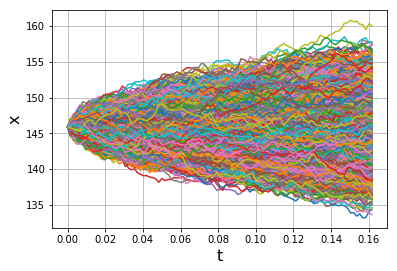

In [32]:
path = np.linspace(0.0, t, step+1)
for k in range(simulations):
    plt.plot(path, S_mat[k])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.grid(True)
# plt.savefig('MC_BM.png')   # save the figure to file
# plt.close()

## 5.2 Plots: Errors between two MC methods and number of simulations

0.0001853774374031783
13500
0.0009095384508850406
4500


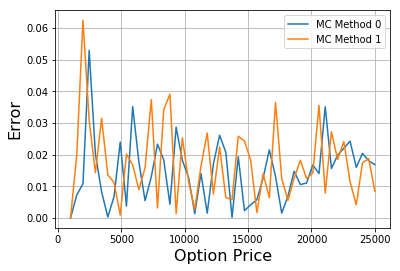

In [248]:
np.random.seed(123)
sets = 50 # number of differed simulations tests
err_diff = np.zeros([2, sets])
for i in range(1000, 500 * (sets+1), 500):
    err_diff[0, int(i/500 - 1)] = abs(Option_MC1(S, K, r, r_diff, v, t, step, i)
                                        - price_BS)/price_BS
    err_diff[1, int(i/500 - 1)] = abs(Option_MC2(S, K, r, r_diff, v, t, step, i)
                                        - price_BS)/price_BS
print(min(err_diff[0,1:]))  # minimal error for Euler MC
print(1000 + 500 * np.argmin(err_diff[0,1:]))   # number of simulations
print(min(err_diff[1,1:]))  # minimal error for Milstein MC
print(1000 + 500 * np.argmin(err_diff[1,1:]))   # number of simulations
path = np.linspace(1000, 500 * sets, sets)
for k in range(2):
    plt.plot(path, err_diff[k], label = 'MC Method %i' %k)
plt.legend(loc='upper right')
plt.xlabel('Option Price', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.grid(True)
# plt.savefig('OP_err_new.png')
# plt.close()

## 5.3 Plots: Volatility Smile: out of money calls and puts

In [241]:
S = 145.88  # S = price of the underlying asset
K = 146  # K = strike price of the option
# Open interest is the total number of open or outstanding options and/or futures contracts that exist at a given time. 

call_out = call[ (call.loc[:, 'Strike Price'] >= S) & (call.loc[:, 'Interest'] != 'n.a.') ]
call_out.loc[:, ('Bid', 'Ask')] = call_out.loc[:, ('Bid', 'Ask')].apply(pd.to_numeric, errors='coerce').fillna(np.nan)
call_out.loc[:,'price_mean'] = (call_out.Bid + call_out.Ask) / 2
call_out = call_out.dropna(axis=0, how='any')
call_out.loc[:,'iv'] = [IV_Newton(call_out.loc[i,'price_mean'], S, call_out.loc[i,'Strike Price'], t, r, r_foreign, v, tolerance, 'call') for i in call_out.index]

put_out = put[ (put.loc[:, 'Strike Price'] < S) & (put.loc[:, 'Interest'] != 'n.a.') ]
put_out.loc[:, ('Bid', 'Ask')] = put_out.loc[:, ('Bid', 'Ask')].apply(pd.to_numeric, errors='coerce').fillna(np.nan)
put_out.loc[:,'price_mean'] = (put_out.Bid + put_out.Ask) / 2
put_out = put_out.dropna(axis=0, how='any')
put_out.loc[:,'iv'] = [IV_Newton(put_out.loc[i,'price_mean'], S, put_out.loc[i,'Strike Price'], t, r, r_foreign, v, tolerance, 'put') for i in put_out.index]

implied_vols = put_out[['Strike Price', 'iv']]
implied_vols = implied_vols.append(call_out[['Strike Price', 'iv']], ignore_index=True)

/anaconda2/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda2/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


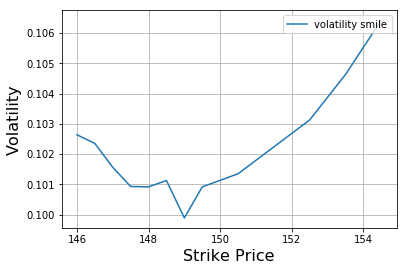

In [242]:
plt.plot(implied_vols[['Strike Price']], implied_vols.iv, label = 'volatility smile')
plt.legend(loc='upper right')
plt.xlabel('Strike Price', fontsize=16)
plt.ylabel('Volatility', fontsize=16)
plt.grid(True)

## 6. Recalculations and Results according to implied volatility

In [252]:
# (i) Black-Scholes Analytic Pricing Formula
v = IV # IV is implied volatility
Option1(S, K, r, r_foreign, v, t, 'call')  # Hockey Stick payoff BS model 1.7730506468902547
price_BS = Option2(S, K, r, r_diff, v, t)    # payoff as Heaviside step

# (ii) Binomial Model
n = 8000  # n: height of the binomial tree
price = Option_Bin(S, K, r, r_diff, v, t, n)    # CRR Parameterization
price2 = Option_Bin2(S, K, r, r_diff, v, t, n)    # The Jarrow-Rudd (JR) parameterisation


# (iii) Monte Carlo
np.random.seed(123)
step = 100  # Number of steps
simulations = 8000  # n: number of simulated paths
price_eul = Option_MC1(S, K, r, r_diff, v, t, step, simulations)  # Euler method # 0.4846761727549967
price_mil = Option_MC2(S, K, r, r_diff, v, t, step, simulations) # Milstein method  0.49237930598001844

# (iv) Implied Volatility
C = np.mean([2.2, 2.34])  # C: Call option value set to be the mean of bid and ask
tolerance = 0.00001
IV = IV_Newton(C, S, K, t, r, r_foreign, v, tolerance, 'call') # 0.08093006414813121

In [257]:
# Difference calculation
price_bin_diff = str(round((abs(price[0, 0] - price_BS) / price_BS) * 100,3)) + '%'   
price2_bin_diff = str(round((abs(price2[0, 0] - price_BS) / price_BS)* 100,3)) + '%'    
price_eul_diff = str(round((abs(price_eul - price_BS) / price_BS)* 100,3)) + '%'  
price_mil_diff = str(round((abs(price_mil - price_BS) / price_BS)* 100,3)) + '%'    
IV_diff = str(round((IV/v - 1)* 100,3)) + '%' 

# summary dataframe
col_names =  ['Models', 'Price/Vol', 'Diff', 'Notes']
pricing  = pd.DataFrame(columns = col_names)
pricing.Models = ['BS Analytic Pricing', 'Binomial Model - CRR', 'Binomial Model - JR', 'Monte Carlo - Euler', 
                  'Monte Carlo - Milstein', 'Volatility for calculation', 'Implied Volatility']
pricing.loc[:,'Price/Vol'] = [price_BS, price[0, 0], price2[0, 0], price_eul, price_mil, v, IV]
pricing.Diff =  ['-', price_bin_diff, price2_bin_diff, price_eul_diff, price_mil_diff, '-', IV_diff]
pricing.Notes = ['-', 'height of the binomial tree  n = 8000',  'height of the binomial tree  n = 8000', 'time step = 100, number of simulations = 8000', 
                 'time step = 100, number of simulations = 8000', 'implied volatility', 'based on tolerance 10^(-5)']
pricing

,Models,Price/Vol,Diff,Notes
0,BS Analytic Pricing,0.473074,-,-
1,Binomial Model - CRR,0.477872,1.014%,height of the binomial tree n = 8000
2,Binomial Model - JR,0.476136,0.647%,height of the binomial tree n = 8000
3,Monte Carlo - Euler,0.461318,2.485%,"time step = 100, number of simulations = 8000"
4,Monte Carlo - Milstein,0.469518,0.752%,"time step = 100, number of simulations = 8000"
5,Volatility for calculation,0.102636,-,implied volatility
6,Implied Volatility,0.102637,0.0%,based on tolerance 10^(-5)
